# Notebook for download GO and select 1000 terms for the analysis 

## Step1: Dowload and process GO_BP terms 

In [1]:
### this function will download go-basic.obo and parse it filtering for biological process branch
# it will output these two files that will be used in the next step:
# collapsed_go.symbol (a network format of GO terms)
# goID_2_name.tab (a mapping of GO terms to their names)

outdir = 'data/GO_BP/'
namespace = 'biological_process'

%run process_the_gene_ontology.py $outdir --namespace $namespace 

/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/ddot/Ontology.py:420: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(gaf, header=None, comment='!', names=gaf_columns)


Number of entries in goa_human.gaf.gz before cleanup: 635268

Number of entries in goa_human.gaf.gz after cleanup: 161332

Unifying 2 roots into one super-root
17795 genes, 11944 terms, 113457 gene-term relations, 27733 term-term relations
node_attributes: []
edge_attributes: []


/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/ddot/Ontology.py:2345: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/ddot/Ontology.py:2347: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._mapping_to_pandas(), ignore_index=True)
154 input query terms found dup hits:	[('A0A075B759', 2), ('A5PLL7', 2), ('A6NGN4', 2), ('B7ZAQ6', 2), ('C9J1S8', 2), ('O14598', 2), ('O14
906 input query terms found no hit:	['A0A075B6H5', 'A0A075B6H7', 'A0A075B6H8', 'A0A075B6H9', 'A0A075B6I0', 'A0A075B6I1', 'A0A075B6I3', '
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/ddot/Ontology.py:2244: FutureWarning: inplace is deprecated and will

17023 genes, 11944 terms, 112230 gene-term relations, 27733 term-term relations
node_attributes: ['Term_Description', 'Branch']
edge_attributes: []


154 input query terms found dup hits:	[('A0A075B759', 2), ('A5PLL7', 2), ('A6NGN4', 2), ('B7ZAQ6', 2), ('C9J1S8', 2), ('O14598', 2), ('O14
906 input query terms found no hit:	['A0A075B6H5', 'A0A075B6H7', 'A0A075B6H8', 'A0A075B6H9', 'A0A075B6I0', 'A0A075B6I1', 'A0A075B6I3', '
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/ddot/Ontology.py:2244: FutureWarning: inplace is deprecated and will be removed in a future version.
  idx.set_levels([idx.levels[0].map(f), idx.levels[1].map(f)], inplace=True)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/ddot/Ontology.py:2345: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(self._hierarchy_to_pandas(), ignore_index=True)
/cellar/users/mhu/miniconda3/envs/llm_eval/lib/python3.11/site-packages/ddot/Ontology.py:2347: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

17023 genes, 11944 terms, 112230 gene-term relations, 27733 term-term relations
node_attributes: ['Term_Description', 'Branch']
edge_attributes: []


In [2]:
import networkx as nx
import pandas as pd
# function specific to loading the collapsed_go.symbol type file
def load_go(filename): 
    # Create an empty directed graph
    G = nx.DiGraph()

    with open(filename, 'r') as f:
        for line in f:
            columns = line.strip().split('\t')  # tab-separated values
            if len(columns) >= 3:
                parent = columns[0] # based on collapsed_go.symbol, the first column is parent
                child = columns[1] # second column is child
                interaction = columns[2] # third column is interaction type
                # Add an edge to the graph
                G.add_edge(parent, child, interaction=interaction)

    # Get the set of all genes
    hiergeneset = set(n for n in G.nodes() if not n.startswith('GO:'))

    # Get term statistics
    df = get_termStats(G, hiergeneset)

    return df

def get_termStats(G, hiergeneset):
    clusters = list(set(list(G.nodes())) - hiergeneset) #
    tsize_list = []
    cgene_list = []
    for c in clusters:
        infoset = nx.descendants(G, c) # get all the descendants of the cluster
        cgeneset = infoset.intersection(hiergeneset) # get the genes that are in the cluster
        tsize_list.append(len(cgeneset)) 
        cgene_list.append(list(cgeneset))

    df = pd.DataFrame(index=clusters)
    df['Genes'] = [' '.join(genes) for genes in cgene_list] # convert list to string separated by space
    df['Gene_Count'] = tsize_list # number of genes in the cluster
    return df


In [3]:
## use case
## GO version: latest 2023-11-15

go_terms = load_go('./data/GO_BP/collapsed_go.symbol')
go_terms = go_terms.reset_index().rename(columns={'index': 'GO'}) # rename the index column to column name GO
print(go_terms.shape)

# add the go term description
term_des = pd.read_table('./data/GO_BP/goID_2_name.tab',
                                        header=None,
                                        names=['Term', 'Term_Description'],
                                        index_col=0)
go_terms_des = go_terms.merge(term_des, left_on='GO', right_index=True, how='left')

# check if there are any missing values
print(go_terms_des.isnull().sum())

go_terms_des.to_csv('data/go_terms.csv')
go_terms_des.head()

(11943, 3)
GO                  0
Genes               0
Gene_Count          0
Term_Description    0
dtype: int64


,GO,Genes,Gene_Count,Term_Description
0,GO:0006311,TEX11 PRDM9 RNF212,3,meiotic gene conversion
1,GO:0006855,ABCB11 ABCC4 ABCC3 SLC29A2 SLC37A3 SLC19A1 SLC...,16,xenobiotic transmembrane transport
2,GO:0006890,GOLPH3L ARCN1 GBF1 KDELR1 BET1L PICK1 COPZ2 SC...,52,"retrograde vesicle-mediated transport, Golgi t..."
3,GO:1900372,PARP1 FLCN RD3 PID1,4,negative regulation of purine nucleotide biosy...
4,GO:0031645,LPIN1 HCRT GPR35 EIF2AK3 GLRA1 MTNR1B CCN3 MTM...,16,negative regulation of nervous system process


## Step 2: Understand GO size distribution and select 1000 GO 

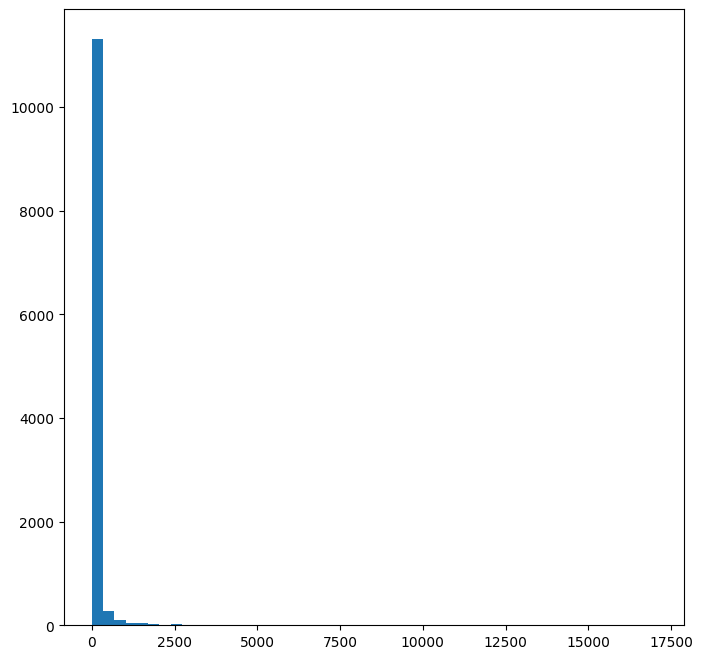

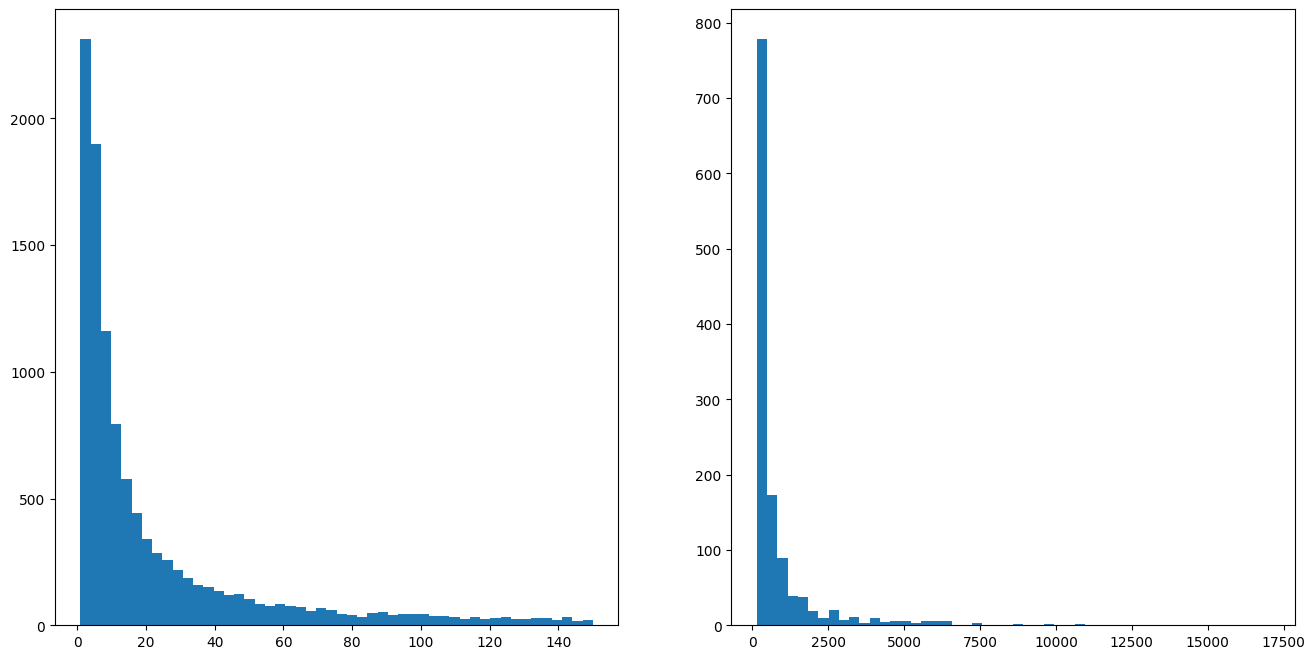

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
go_terms = pd.read_csv('data/go_terms.csv', sep = ',',index_col=0)

plt.figure(figsize=(8,8))
plt.hist(go_terms['Gene_Count'], bins=50)

# subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.hist(go_terms[(go_terms['Gene_Count'] <= 150)]['Gene_Count'], bins=50)
ax2.hist(go_terms[(go_terms['Gene_Count'] > 150)]['Gene_Count'], bins=50)
plt.show()


In [14]:
# if we randomly select GO terms between 3-200, what percentage of terms will be in the pool?
go_terms[(go_terms['Gene_Count'] >= 3) & (go_terms['Gene_Count'] <= 200)].shape[0]/go_terms.shape[0]



0.8071673783806413

        Gene_Count
count  9640.000000
mean     29.252075
std      38.846752
min       3.000000
25%       6.000000
50%      12.000000
75%      34.000000
max     200.000000
(9640, 4)


(array([297., 154.,  86.,  68.,  41.,  45.,  28.,  29.,  24.,  16.,  17.,
         17.,  13.,  10.,  15.,   9.,   7.,  13.,  10.,   4.,   7.,   8.,
          5.,   7.,   3.,   5.,   6.,   7.,   5.,   3.,   1.,   5.,   0.,
          7.,   2.,   1.,   2.,   5.,   1.,   1.,   1.,   1.,   2.,   4.,
          3.,   1.,   1.,   1.,   0.,   2.]),
 array([  3. ,   6.9,  10.8,  14.7,  18.6,  22.5,  26.4,  30.3,  34.2,
         38.1,  42. ,  45.9,  49.8,  53.7,  57.6,  61.5,  65.4,  69.3,
         73.2,  77.1,  81. ,  84.9,  88.8,  92.7,  96.6, 100.5, 104.4,
        108.3, 112.2, 116.1, 120. , 123.9, 127.8, 131.7, 135.6, 139.5,
        143.4, 147.3, 151.2, 155.1, 159. , 162.9, 166.8, 170.7, 174.6,
        178.5, 182.4, 186.3, 190.2, 194.1, 198. ]),
 <BarContainer object of 50 artists>)

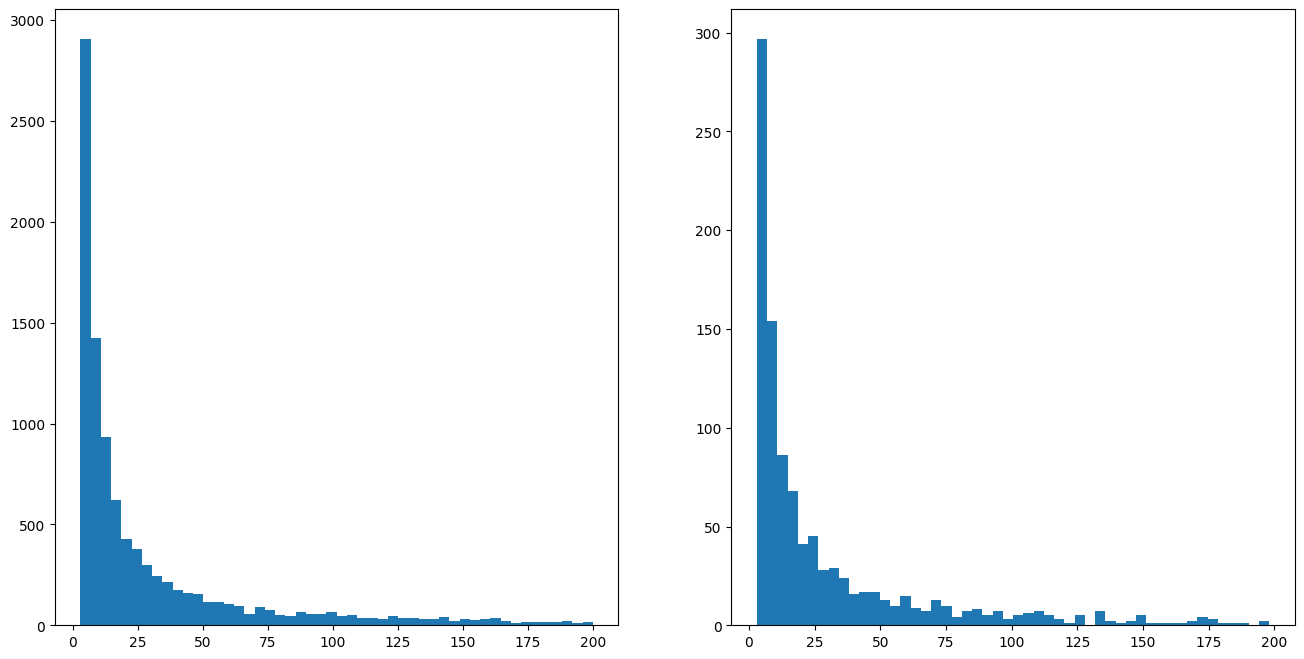

In [22]:
## randomly select 1000 GO terms from the pool between 3-200
import random
import pandas as pd
import numpy as np

SEED = 42
min = 3
max = 200

go_terms = pd.read_csv('data/go_terms.csv', sep = ',',index_col=0)
go_filtered = go_terms[(go_terms['Gene_Count'] >= min) & (go_terms['Gene_Count'] <= max)]
print(go_filtered.describe())
print(go_filtered.shape)

# randomly select 1000 GO terms from the pool between min and max

selected_go = go_filtered.sample(n=1000, random_state=SEED)

selected_go.to_csv('data/GO_term_analysis/1000_selected_go_terms.csv', index=False)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.hist(go_filtered['Gene_Count'], bins=50)
ax2.hist(selected_go['Gene_Count'], bins=50)

In [23]:
print(selected_go.describe())
selected_go.head()

        Gene_Count
count  1000.000000
mean     28.360000
std      36.547395
min       3.000000
25%       6.000000
50%      12.000000
75%      35.000000
max     198.000000


,GO,Genes,Gene_Count,Term_Description
8057,GO:0006667,DEGS2 SPTLC1 SPTLC2,3,sphinganine metabolic process
808,GO:0035519,UBE2T PRKN RNF167 ITCH UBE3C RNF186 TRAF7 UBE2...,9,protein K29-linked ubiquitination
4548,GO:0002885,HLA-E C3 CCR7 BTK FCGR1A ZP3,6,positive regulation of hypersensitivity
1706,GO:1900625,CD44 NR4A3 HAS2,3,positive regulation of monocyte aggregation
7689,GO:1990806,PLCB1 GRIN1 GRIN2A GRIK5 GRIN2C GRIK1 GRID1 GR...,33,ligand-gated ion channel signaling pathway


In [26]:
# extract a subset of 10 GO terms as a toy example
import pandas as pd
df = pd.read_csv('data/GO_term_analysis/1000_selected_go_terms.csv')
# take random 10 GO terms 
SEED = 42
toy = df.sample(n=10, random_state=SEED)
toy.to_csv('data/GO_term_analysis/toy_example.csv', index=False)
